In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
from scipy import optimize

from scipy.io import savemat

from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=5)


with open('YALE_Shortness_of_Breath.npy', 'rb') as f:
    X_train = np.load(f)
    y_train = np.load(f).reshape(-1)
    X_test = np.load(f)
    y_test = np.load(f).reshape(-1)

classes = ['0', '1']
classes_name = ['Discharged', 'Admitted']

X_all = np.concatenate((X_train,X_test))
y_all = np.concatenate((np.zeros(X_train.shape[0]), np.ones(X_test.shape[0])))

n = X_train.shape[0]
    
print(X_train.shape, y_train.shape, X_train.dtype)
print(X_test.shape, y_test.shape, X_test.dtype)
print(X_all.shape, y_all.shape, X_all.dtype)

y_labels = np.concatenate((y_train,y_test))
print(np.sum(y_labels==0), np.sum(y_labels==1))

DPI = 400

%matplotlib inline

%load_ext autoreload
%autoreload 2

(19721, 1003) (19721,) float64
(4931, 1003) (4931,) float64
(24652, 1003) (24652,) float64
8861 15791


In [2]:
import numba
from numba import prange

@numba.jit(nopython=True, parallel=True)
def get_first_order_graph(X,n_neighbors):
    
    N = X.shape[0]
    
    dist = np.zeros((N, N), dtype=np.float32)
    #euclidean_distances(X_train, squared = False)

    sort_idx = np.zeros((N,n_neighbors), dtype=np.int32)
    
    for i in range(N):
        if (i+1)%10000 == 0:
            print('Completed ', i+1, ' of ', N)
        
        for j in prange(i+1,N):
            dist[i,j] = np.sum( (X[i]-X[j])**2 )
            dist[j,i] = dist[i,j]
        
        sort_idx[i,:] = np.argsort(dist[i,:])[1:n_neighbors+1]
    
    return sort_idx, dist

@numba.jit(nopython=True, parallel=True)
def my_trustworthiness(Y,sort_idx,K):
    N = Y.shape[0]

    val = 0.0
    for i in prange(N):
        dist = np.sum((Y - Y[i,:])**2,axis=1)
        
        #print(dist.shape)
        
        sort_idy = np.argsort(dist)[1:]
        for j in prange(K):
            r_0 = np.argwhere(sort_idy[j]==sort_idx[i,:])
            #print(i, r_0, sort_idx[i,j])
            #print(sort_idy)
            r = r_0[0,0] 
            #print(i,r)
            #print(sort_idx[i,j])
            #print(sort_idy)
            r_v = r - K + 1
            if r_v>0:
                val += r_v
        #print(val)
    #print(val)
    val = val * 2.0 / ( N*K * (2*N - 3*K - 1.0))
    
    #print(val)
    
    return 1 - val



In [3]:
def fig_plot(X,y,filename):
    plt.figure(figsize=[6,5])
    plt.scatter(X[:,0], X[:,1], c=y, s=0.1, cmap='Spectral')
    
    plt.xticks([],[])
    plt.yticks([],[])
    
    plt.savefig('Shortness/'+filename, bbox_inches='tight')

    return

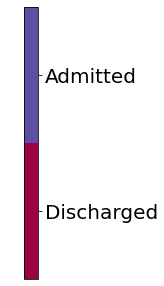

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=[6,5])

fraction = 1  # .05

classes = ['Discharged',
          'Admitted']#,
          #'Discharged (Test)',
          #'Admitted (Test)']

values = np.arange(len(classes))

norm = mpl.colors.Normalize(vmin=values[0], vmax=values[-1])
cbar = ax.figure.colorbar(
            mpl.cm.ScalarMappable(norm=norm, cmap='Spectral'),
            boundaries=np.arange(len(classes)+1)-0.5,
            ax=ax, fraction=fraction)
cbar.set_ticks(np.arange(len(classes)))
cbar.set_ticklabels(classes)
cbar.ax.tick_params(labelsize=20)

ax.margins(0,0)

ax.axis('off')
plt.show()

fig.savefig('Shortness/yale_short_colorbar.png', bbox_inches='tight')

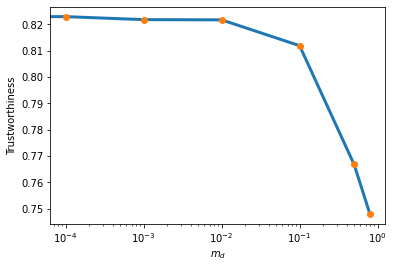

In [5]:


'''
from sklearn.manifold import trustworthiness

import umap

mindists = [0, 0.0001, 0.001, 0.01, 0.1, 0.5, 0.8, 1.0]

for min_dist in mindists:

    np.random.seed(100)
    ump = umap.UMAP(n_neighbors=30,
            min_dist=min_dist,
            n_components=2,
            random_state=150,
            metric= 'euclidean')

    y_umap_it = ump.fit_transform(X_train)
    #y_umap_test = ump.transform(X_test)
    tt_tr_te_5_it = trustworthiness(X_train, y_umap_it, n_neighbors=5)

    print(min_dist, ', Trustworthiness: ', tt_tr_te_5_it)
'''
temp = 0
#Random State 150
#0 , Trustworthiness:  0.8224398733457383
#0.0001 , Trustworthiness:  0.8229286169518751
#0.001 , Trustworthiness:  0.8217963962569788
#0.01 , Trustworthiness:  0.821706055189469
#0.1 , Trustworthiness:  0.8118921018928814
#0.5 , Trustworthiness:  0.7667556683476597
#0.8 , Trustworthiness:  0.7478230178231292


mindists = [0, 0.0001, 0.001, 0.01, 0.1, 0.5, 0.8]
val = [0.8224398733457383, 0.8229286169518751, 0.8217963962569788, 0.821706055189469, 0.8118921018928814, 0.7667556683476597, 0.7478230178231292]

plt.figure()
plt.semilogx(mindists, val, linewidth=3)
plt.semilogx(mindists, val, 'o')
plt.xlabel(r'$m_d$')
plt.ylabel('Trustworthiness')
plt.savefig('turstworthiness_yale_shortness.png', dpi=400)

In [6]:
sort_idx,_ = get_first_order_graph(X_all,n_neighbors=X_all.shape[0]-1)

/home/ponir/.local/lib/python3.6/site-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


Completed  10000  of  24652
Completed  20000  of  24652


In [7]:
sort_idx_tr,_ = get_first_order_graph(X_train,n_neighbors=X_train.shape[0]-1)

Completed  10000  of  19721


<h1>UMAP</h1>

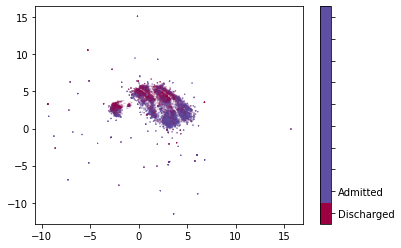

In [8]:
#with open('YALE_ABDOMINAL_PAIN_UMAP_TR_TE_30.npy', 'rb') as f:
#    y_tr_te = np.load(f)
#    y_all = np.load(f)

import umap

np.random.seed(100)
ump = umap.UMAP(n_neighbors=30,
        min_dist=0.0001,
        n_components=2,
        random_state=150,
        metric= 'euclidean')

y_umap = ump.fit_transform(X_train)
y_umap_test = ump.transform(X_test)

plt.figure()
plt.scatter(y_umap[:,0], y_umap[:,1], c=y_train, s=0.01, cmap='Spectral')

cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)

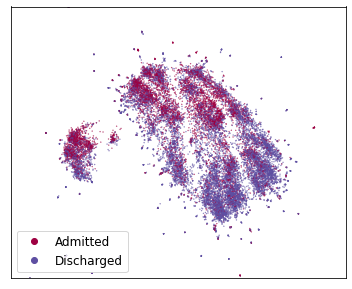

In [9]:
t_umap_tr_te = np.concatenate((y_umap,y_umap_test))
y_umap_tr_te = np.concatenate((y_train, y_test+2))


plt.figure(figsize=[6,5])
#plt.scatter(t_umap_tr_te[:,0], t_umap_tr_te[:,1], 
#            c=y_umap_tr_te, s=0.1, cmap='Spectral')

scatter = plt.scatter(y_umap[:,0], y_umap[:,1], 
            c=y_train, s=0.1, cmap='Spectral')

plt.xlim([-5,8])
plt.ylim([-2,8])

plt.xticks([])
plt.yticks([])

lgd = plt.legend(*scatter.legend_elements(),
                    loc="lower left",
                    fontsize=12)
lgd.get_texts()[0].set_text('Admitted') #PA
lgd.get_texts()[1].set_text('Discharged') #AP

plt.savefig('Shortness/yale_short_umap.png', bbox_inches='tight', dpi=DPI)

#Create the Colorbar

#cbar = plt.colorbar() #boundaries=np.arange(11)-0.5

In [10]:
from sklearn.neighbors import KNeighborsClassifier

print('Nearest Neighbor: UMAP (TRAIN->TEST)')

neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(y_umap, y_train)

y_nene_out = neigh.predict(y_umap_test)

err_tsne = 1-np.mean(y_nene_out==y_test)

print('1-NN error: ', err_tsne)

from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(y_umap, y_train)

y_nene_out = neigh.predict(y_umap_test)

err_tsne_5 = 1-np.mean(y_nene_out==y_test)
print('5-NN error: ', err_tsne_5)

Nearest Neighbor: UMAP (TRAIN->TEST)
1-NN error:  0.3540863922125329
5-NN error:  0.3145406611235043


In [11]:
t_umap_tr_te = np.concatenate((y_umap,y_umap_test))

tt_tr_te_5 = my_trustworthiness(t_umap_tr_te, sort_idx, K=5)
tt_tr_te_30 = my_trustworthiness(t_umap_tr_te, sort_idx, K=30)
tt_tr_te_100 = my_trustworthiness(t_umap_tr_te, sort_idx, K=100)

print('Trustworthiness: UMAP (TRAIN->TEST)')
print('5: ', tt_tr_te_5)
print('30: ', tt_tr_te_30)
print('100: ', tt_tr_te_100)


t_umap_tr_te = np.concatenate((y_umap,y_umap_test))

tt_tr_te_5 = my_trustworthiness(y_umap, sort_idx_tr, K=5)
tt_tr_te_30 = my_trustworthiness(y_umap, sort_idx_tr, K=30)
tt_tr_te_100 = my_trustworthiness(y_umap, sort_idx_tr, K=100)

print('Trustworthiness: UMAP (TRAIN)')
print('5: ', tt_tr_te_5)
print('30: ', tt_tr_te_30)
print('100: ', tt_tr_te_100)



Trustworthiness: UMAP (TRAIN->TEST)
5:  0.8159121430300038
30:  0.7942342648527149
100:  0.7817543678154804
Trustworthiness: UMAP (TRAIN)
5:  0.8229286138651384
30:  0.794806488276701
100:  0.7819020861054634


In [12]:
#check the result with Scikit Learn Implementation
from sklearn.manifold import trustworthiness

t_umap_tr_te = np.concatenate((y_umap,y_umap_test))

tt_tr_te_5 = trustworthiness(X_all, t_umap_tr_te, n_neighbors=5)
tt_tr_te_30 = trustworthiness(X_all, t_umap_tr_te, n_neighbors=30)
tt_tr_te_100 = trustworthiness(X_all, t_umap_tr_te, n_neighbors=100)

print('Trustworthiness: UMAP (TRAIN->TEST)')
print('5: ', tt_tr_te_5)
print('30: ', tt_tr_te_30)
print('100: ', tt_tr_te_100)


t_umap_tr_te = np.concatenate((y_umap,y_umap_test))

tt_tr_te_5 = trustworthiness(X_train, y_umap, n_neighbors=5)
tt_tr_te_30 = trustworthiness(X_train, y_umap, n_neighbors=30)
tt_tr_te_100 = trustworthiness(X_train, y_umap, n_neighbors=100)

print('Trustworthiness: UMAP (TRAIN)')
print('5: ', tt_tr_te_5)
print('30: ', tt_tr_te_30)
print('100: ', tt_tr_te_100)



Trustworthiness: UMAP (TRAIN->TEST)
5:  0.8159121476388761
30:  0.7942342628744736
100:  0.7817543663254412
Trustworthiness: UMAP (TRAIN)
5:  0.8229286169518751
30:  0.7948064893075742
100:  0.7819020865459352


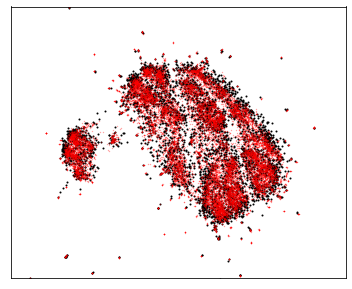

In [13]:
y_all = np.concatenate((np.zeros(X_train.shape[0]), np.ones(X_test.shape[0])))
#plt.figure(figsize=(15,15))
plt.figure(figsize=[6,5])
c1 = 'k'
c2 = 'r'
plt.scatter(y_umap_test[:,0], y_umap_test[:,1], c=c1, s=1.0)
plt.scatter(y_umap[:,0], y_umap[:,1], c=c2, s=0.1, alpha=0.5)


classes_tr = ['train', 'test']

plt.xlim([-5,8])
plt.ylim([-2,8])

plt.xticks([])
plt.yticks([])

plt.savefig('Shortness/yale_short_umap_repulsioneffect.png', bbox_inches='tight', dpi=DPI)

<h1>UMAP n_s=3</h1>

5


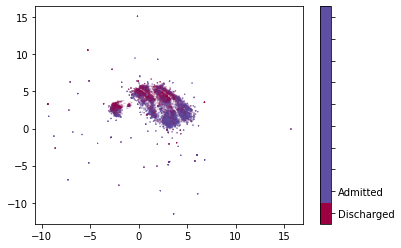

In [14]:
import umap

np.random.seed(100)
ump = umap.UMAP(n_neighbors=30,
        min_dist=0.0001,
        n_components=2,
        random_state=150,
        metric= 'euclidean')

print(ump.negative_sample_rate)
y_umap = ump.fit_transform(X_train)
ump.negative_sample_rate = 3
y_umap_test = ump.transform(X_test)

plt.figure()
plt.scatter(y_umap[:,0], y_umap[:,1], c=y_train, s=0.01, cmap='Spectral')

cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)

In [15]:
t_umap_tr_te = np.concatenate((y_umap,y_umap_test))
y_umap_tr_te = np.concatenate((y_train, y_test+2))


from sklearn.neighbors import KNeighborsClassifier

print('Nearest Neighbor: UMAP (n_s=3) (TRAIN->TEST)')

neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(y_umap, y_train)

y_nene_out = neigh.predict(y_umap_test)

err_tsne = 1-np.mean(y_nene_out==y_test)

print('1-NN error: ', err_tsne)

from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(y_umap, y_train)

y_nene_out = neigh.predict(y_umap_test)

err_tsne_5 = 1-np.mean(y_nene_out==y_test)
print('5-NN error: ', err_tsne_5)

Nearest Neighbor: UMAP (n_s=3) (TRAIN->TEST)
1-NN error:  0.35368079497059424
5-NN error:  0.30602311904279056


In [16]:
t_umap_tr_te = np.concatenate((y_umap,y_umap_test))

tt_tr_te_5 = my_trustworthiness(t_umap_tr_te, sort_idx, K=5)
tt_tr_te_30 = my_trustworthiness(t_umap_tr_te, sort_idx, K=30)
tt_tr_te_100 = my_trustworthiness(t_umap_tr_te, sort_idx, K=100)

print('Trustworthiness: UMAP (n_s=3) (TRAIN->TEST)')
print('5: ', tt_tr_te_5)
print('30: ', tt_tr_te_30)
print('100: ', tt_tr_te_100)


t_umap_tr_te = np.concatenate((y_umap,y_umap_test))

tt_tr_te_5 = my_trustworthiness(y_umap, sort_idx_tr, K=5)
tt_tr_te_30 = my_trustworthiness(y_umap, sort_idx_tr, K=30)
tt_tr_te_100 = my_trustworthiness(y_umap, sort_idx_tr, K=100)

print('Trustworthiness: UMAP (n_s=3) (TRAIN)')
print('5: ', tt_tr_te_5)
print('30: ', tt_tr_te_30)
print('100: ', tt_tr_te_100)

#Trustworthiness: UMAP (TRAIN->TEST)
#5:  0.8159121476388761
#30:  0.7942342628744736
#100:  0.7817543663254412


Trustworthiness: UMAP (n_s=3) (TRAIN->TEST)
5:  0.8178560066760701
30:  0.7957754739957408
100:  0.7827943748565445
Trustworthiness: UMAP (n_s=3) (TRAIN)
5:  0.8229286138651384
30:  0.794806488276701
100:  0.7819020861054634


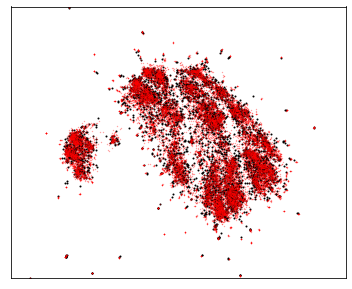

In [17]:
y_all = np.concatenate((np.zeros(X_train.shape[0]), np.ones(X_test.shape[0])))
#plt.figure(figsize=(15,15))
plt.figure(figsize=[6,5])
plt.scatter(y_umap_test[:,0], y_umap_test[:,1], c=c1, s=1.0)
plt.scatter(y_umap[:,0], y_umap[:,1], c=c2, s=0.1, alpha=0.5)


classes_tr = ['train', 'test']

plt.xlim([-5,8])
plt.ylim([-2,8])

plt.xticks([])
plt.yticks([])

plt.savefig('Shortness/yale_short_umap_repulsioneffect_ns3.png', bbox_inches='tight', dpi=DPI)

<h1>UMAP n_s=2</h1>

5


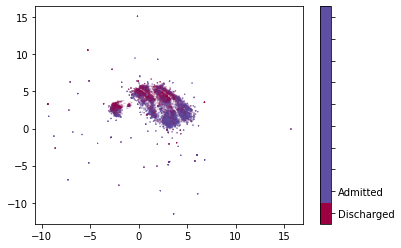

In [18]:
import umap

np.random.seed(100)
ump = umap.UMAP(n_neighbors=30,
        min_dist=0.0001,
        n_components=2,
        random_state=150,
        metric= 'euclidean')

print(ump.negative_sample_rate)
y_umap = ump.fit_transform(X_train)
ump.negative_sample_rate = 2
y_umap_test = ump.transform(X_test)

plt.figure()
plt.scatter(y_umap[:,0], y_umap[:,1], c=y_train, s=0.01, cmap='Spectral')

cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)

In [19]:
t_umap_tr_te = np.concatenate((y_umap,y_umap_test))
y_umap_tr_te = np.concatenate((y_train, y_test+2))


from sklearn.neighbors import KNeighborsClassifier

print('Nearest Neighbor: UMAP (n_s=2) (TRAIN->TEST)')

neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(y_umap, y_train)

y_nene_out = neigh.predict(y_umap_test)

err_tsne = 1-np.mean(y_nene_out==y_test)

print('1-NN error: ', err_tsne)

from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(y_umap, y_train)

y_nene_out = neigh.predict(y_umap_test)

err_tsne_5 = 1-np.mean(y_nene_out==y_test)
print('5-NN error: ', err_tsne_5)

Nearest Neighbor: UMAP (n_s=2) (TRAIN->TEST)
1-NN error:  0.3502332184141148
5-NN error:  0.3046035286960048


In [20]:
t_umap_tr_te = np.concatenate((y_umap,y_umap_test))

tt_tr_te_5 = my_trustworthiness(t_umap_tr_te, sort_idx, K=5)
tt_tr_te_30 = my_trustworthiness(t_umap_tr_te, sort_idx, K=30)
tt_tr_te_100 = my_trustworthiness(t_umap_tr_te, sort_idx, K=100)

print('Trustworthiness: UMAP (n_s=2) (TRAIN->TEST)')
print('5: ', tt_tr_te_5)
print('30: ', tt_tr_te_30)
print('100: ', tt_tr_te_100)


t_umap_tr_te = np.concatenate((y_umap,y_umap_test))

tt_tr_te_5 = my_trustworthiness(y_umap, sort_idx_tr, K=5)
tt_tr_te_30 = my_trustworthiness(y_umap, sort_idx_tr, K=30)
tt_tr_te_100 = my_trustworthiness(y_umap, sort_idx_tr, K=100)

print('Trustworthiness: UMAP (n_s=2) (TRAIN)')
print('5: ', tt_tr_te_5)
print('30: ', tt_tr_te_30)
print('100: ', tt_tr_te_100)

#Trustworthiness: UMAP (TRAIN->TEST)
#5:  0.8159121476388761
#30:  0.7942342628744736
#100:  0.7817543663254412


Trustworthiness: UMAP (n_s=2) (TRAIN->TEST)
5:  0.8178614036654968
30:  0.7953238849961919
100:  0.7826974188207553
Trustworthiness: UMAP (n_s=2) (TRAIN)
5:  0.8229286138651384
30:  0.794806488276701
100:  0.7819020861054634


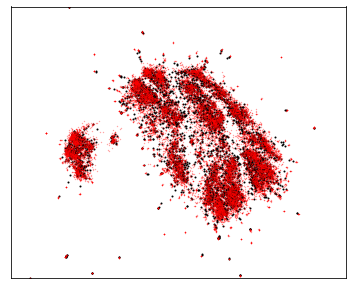

In [21]:
y_all = np.concatenate((np.zeros(X_train.shape[0]), np.ones(X_test.shape[0])))
#plt.figure(figsize=(15,15))
plt.figure(figsize=[6,5])
plt.scatter(y_umap_test[:,0], y_umap_test[:,1], c=c1, s=1.0)
plt.scatter(y_umap[:,0], y_umap[:,1], c=c2, s=0.1, alpha=0.5)


classes_tr = ['train', 'test']

plt.xlim([-5,8])
plt.ylim([-2,8])

plt.xticks([])
plt.yticks([])

plt.savefig('Shortness/yale_short_umap_repulsioneffect_ns2.png', bbox_inches='tight', dpi=DPI)

<h1>UMAP n_s=1</h1>

5


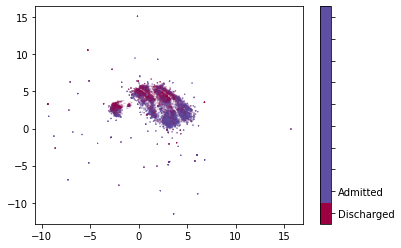

In [22]:
import umap

np.random.seed(100)
ump = umap.UMAP(n_neighbors=30,
        min_dist=0.0001,
        n_components=2,
        random_state=150,
        metric= 'euclidean')

print(ump.negative_sample_rate)
y_umap = ump.fit_transform(X_train)
ump.negative_sample_rate = 2
y_umap_test = ump.transform(X_test)

plt.figure()
plt.scatter(y_umap[:,0], y_umap[:,1], c=y_train, s=0.01, cmap='Spectral')

cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)

In [23]:
t_umap_tr_te = np.concatenate((y_umap,y_umap_test))
y_umap_tr_te = np.concatenate((y_train, y_test+2))


from sklearn.neighbors import KNeighborsClassifier

print('Nearest Neighbor: UMAP (n_s=1) (TRAIN->TEST)')

neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(y_umap, y_train)

y_nene_out = neigh.predict(y_umap_test)

err_tsne = 1-np.mean(y_nene_out==y_test)

print('1-NN error: ', err_tsne)

from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(y_umap, y_train)

y_nene_out = neigh.predict(y_umap_test)

err_tsne_5 = 1-np.mean(y_nene_out==y_test)
print('5-NN error: ', err_tsne_5)

Nearest Neighbor: UMAP (n_s=1) (TRAIN->TEST)
1-NN error:  0.3502332184141148
5-NN error:  0.3046035286960048


In [24]:
t_umap_tr_te = np.concatenate((y_umap,y_umap_test))

tt_tr_te_5 = my_trustworthiness(t_umap_tr_te, sort_idx, K=5)
tt_tr_te_30 = my_trustworthiness(t_umap_tr_te, sort_idx, K=30)
tt_tr_te_100 = my_trustworthiness(t_umap_tr_te, sort_idx, K=100)

print('Trustworthiness: UMAP (n_s=1) (TRAIN->TEST)')
print('5: ', tt_tr_te_5)
print('30: ', tt_tr_te_30)
print('100: ', tt_tr_te_100)


t_umap_tr_te = np.concatenate((y_umap,y_umap_test))

tt_tr_te_5 = my_trustworthiness(y_umap, sort_idx_tr, K=5)
tt_tr_te_30 = my_trustworthiness(y_umap, sort_idx_tr, K=30)
tt_tr_te_100 = my_trustworthiness(y_umap, sort_idx_tr, K=100)

print('Trustworthiness: UMAP (n_s=1) (TRAIN)')
print('5: ', tt_tr_te_5)
print('30: ', tt_tr_te_30)
print('100: ', tt_tr_te_100)

#Trustworthiness: UMAP (TRAIN->TEST)
#5:  0.8159121476388761
#30:  0.7942342628744736
#100:  0.7817543663254412


Trustworthiness: UMAP (n_s=1) (TRAIN->TEST)
5:  0.8178614036654968
30:  0.7953238849961919
100:  0.7826974188207553
Trustworthiness: UMAP (n_s=1) (TRAIN)
5:  0.8229286138651384
30:  0.794806488276701
100:  0.7819020861054634


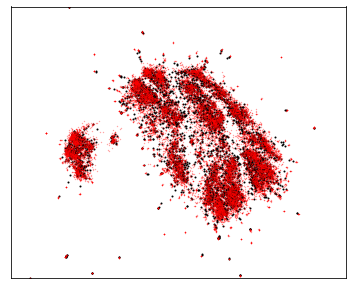

In [25]:
y_all = np.concatenate((np.zeros(X_train.shape[0]), np.ones(X_test.shape[0])))
#plt.figure(figsize=(15,15))
plt.figure(figsize=[6,5])
plt.scatter(y_umap_test[:,0], y_umap_test[:,1], c=c1, s=1.0)
plt.scatter(y_umap[:,0], y_umap[:,1], c=c2, s=0.1, alpha=0.5)


classes_tr = ['train', 'test']

plt.xlim([-5,8])
plt.ylim([-2,8])

plt.xticks([])
plt.yticks([])

plt.savefig('Shortness/yale_short_umap_repulsioneffect_ns1.png', bbox_inches='tight', dpi=DPI)

<h1>UMAP k=15</h1>

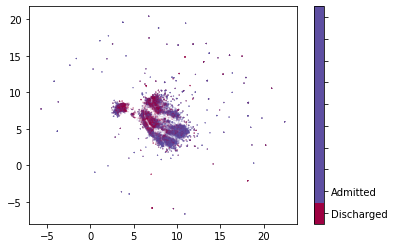

In [26]:
import umap

np.random.seed(100)
ump = umap.UMAP(n_neighbors=15,
        min_dist=0.0001,
        n_components=2,
        random_state=150,
        metric= 'euclidean')

y_umap_15 = ump.fit_transform(X_train)
y_umap_test_15 = ump.transform(X_test)

plt.figure()
plt.scatter(y_umap_15[:,0], y_umap_15[:,1], c=y_train, s=0.01, cmap='Spectral')

cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)

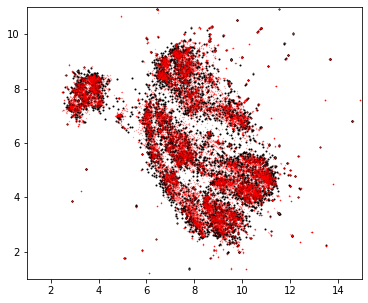

In [27]:
#y_all = np.concatenate((np.zeros(X_train.shape[0]), np.ones(X_test.shape[0])))
#plt.figure(figsize=(15,15))
plt.figure(figsize=[6,5])
plt.scatter(y_umap_test_15[:,0], y_umap_test_15[:,1], c=c1, s=1.0)
plt.scatter(y_umap_15[:,0], y_umap_15[:,1], c=c2, s=0.1, alpha=0.5)


classes_tr = ['train', 'test']

plt.xlim([1,15])
plt.ylim([1,11])

#plt.xticks([])
#plt.yticks([])

plt.savefig('Shortness/yale_short_umap_15_neib_repulsioneffect.png', bbox_inches='tight', dpi=DPI)

<h1>UMAP k=10</h1>

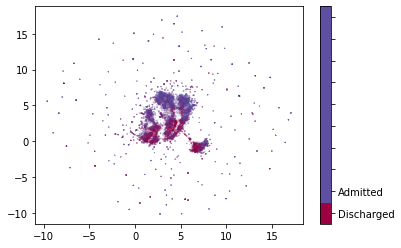

In [28]:
import umap

np.random.seed(100)
ump_10 = umap.UMAP(n_neighbors=10,
        min_dist=0.0001,
        n_components=2,
        random_state=150,
        metric= 'euclidean')

y_umap_10 = ump_10.fit_transform(X_train)
y_umap_test_10 = ump_10.transform(X_test)

plt.figure()
plt.scatter(y_umap_10[:,0], y_umap_10[:,1], c=y_train, s=0.01, cmap='Spectral')

cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)

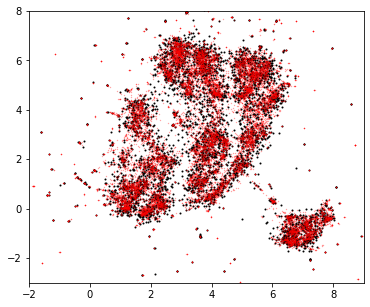

In [29]:
#y_all = np.concatenate((np.zeros(X_train.shape[0]), np.ones(X_test.shape[0])))
#plt.figure(figsize=(15,15))
plt.figure(figsize=[6,5])
plt.scatter(y_umap_test_10[:,0], y_umap_test_10[:,1], c=c1, s=1.0)
plt.scatter(y_umap_10[:,0], y_umap_10[:,1], c=c2, s=0.1, alpha=0.5)


classes_tr = ['train', 'test']

plt.xlim([-2,9])
plt.ylim([-3,8])

#plt.xticks([])
#plt.yticks([])

plt.savefig('Shortness/yale_short_umap_10_neib_repulsioneffect.png', bbox_inches='tight', dpi=DPI)

<h1>UMAP ALL</h1>

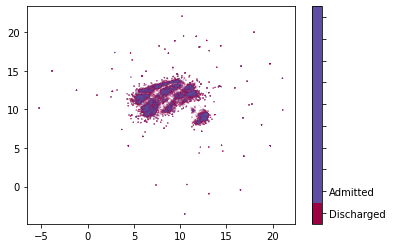

In [30]:
import umap

np.random.seed(100)
ump = umap.UMAP(n_neighbors=30,
        min_dist=0.0001,
        n_components=2,
        random_state=150,
        metric= 'euclidean')

t_umap_all = ump.fit_transform(X_all)

plt.figure()
plt.scatter(t_umap_all[:,0], t_umap_all[:,1], c=y_all, s=0.01, cmap='Spectral')

cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)

In [31]:
t_umap_all_train = t_umap_all[:X_train.shape[0]]
t_umap_all_test = t_umap_all[X_train.shape[0]:]

#t_umap_tr_te = np.concatenate((y_umap,y_umap_test))
#y_umap_tr_te = np.concatenate((y_train, y_test+2))


from sklearn.neighbors import KNeighborsClassifier

print('Nearest Neighbor: UMAP (ALL) (TRAIN->TEST)')

neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(t_umap_all_train, y_train)

y_nene_out = neigh.predict(t_umap_all_test)

err_tsne = 1-np.mean(y_nene_out==y_test)

print('1-NN error: ', err_tsne)

from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(t_umap_all_train, y_train)

y_nene_out = neigh.predict(t_umap_all_test)

err_tsne_5 = 1-np.mean(y_nene_out==y_test)
print('5-NN error: ', err_tsne_5)

Nearest Neighbor: UMAP (ALL) (TRAIN->TEST)
1-NN error:  0.3520584060028392
5-NN error:  0.3029811397282498


In [32]:
tt_all_5 = my_trustworthiness(t_umap_all, sort_idx, K=5)
tt_all_30 = my_trustworthiness(t_umap_all, sort_idx, K=30)
tt_all_100 = my_trustworthiness(t_umap_all, sort_idx, K=100)

print('Trustworthiness: (UMAP ALL)')
print('5: ', tt_all_5)
print('30: ', tt_all_30)
print('100: ', tt_all_100)

tt_tr_te_5 = my_trustworthiness(t_umap_all[:X_train.shape[0]], sort_idx_tr, K=5)
tt_tr_te_30 = my_trustworthiness(t_umap_all[:X_train.shape[0]], sort_idx_tr, K=30)
tt_tr_te_100 = my_trustworthiness(t_umap_all[:X_train.shape[0]], sort_idx_tr, K=100)

print('Trustworthiness: UMAP (TRAIN)')
print('5: ', tt_tr_te_5)
print('30: ', tt_tr_te_30)
print('100: ', tt_tr_te_100)



Trustworthiness: (UMAP ALL)
5:  0.8303352690552968
30:  0.8004481196590448
100:  0.7853305839418038
Trustworthiness: UMAP (TRAIN)
5:  0.828319798674387
30:  0.797460416627872
100:  0.7828617246924792


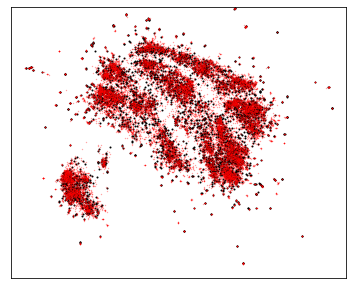

In [33]:
#plt.figure(figsize=(15,15))
plt.figure(figsize=[6,5])
plt.scatter(-t_umap_all[X_train.shape[0]:,0], t_umap_all[X_train.shape[0]:,1], c=c1, s=1.0)
plt.scatter(-t_umap_all[:X_train.shape[0],0], t_umap_all[:X_train.shape[0],1], c=c2, s=0.1, alpha=0.5)


classes_tr = ['train', 'test']

plt.xlim([-15,-2])
plt.ylim([6,15])

plt.xticks([])
plt.yticks([])

plt.savefig('Shortness/yale_short_all_repulsioneffect.png', bbox_inches='tight', dpi=DPI)

<h1>UMAP CE</h1>

In [34]:
from scipy.io import loadmat

d = loadmat('nets_fmnist_PCA_INIT_NEW/test_data19.mat')
t_ce = d['Y'].copy()
t_ce_test = d['Y_test'].copy()
t_ce_tr_te = np.concatenate((d['Y'],d['Y_test'])).copy()


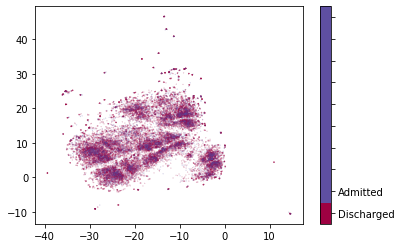

In [35]:
plt.figure()
plt.scatter(t_ce_tr_te[:,0], t_ce_tr_te[:,1], c=y_all, s=0.01, cmap='Spectral')

cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)

In [36]:
from sklearn.neighbors import KNeighborsClassifier

print('Nearest Neighbor: UMAP CE (TRAIN->TEST)')

neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(t_ce, y_train)

y_nene_out = neigh.predict(t_ce_test)

err_tsne = 1-np.mean(y_nene_out==y_test)

print('1-NN error: ', err_tsne)

from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(t_ce, y_train)

y_nene_out = neigh.predict(t_ce_test)

err_tsne_5 = 1-np.mean(y_nene_out==y_test)
print('5-NN error: ', err_tsne_5)

#Epoch 29
#Nearest Neighbor: UMAP (TRAIN->TEST)
#1-NN error:  0.39243302954984816
#5-NN error:  0.34778606278192026

Nearest Neighbor: UMAP CE (TRAIN->TEST)
1-NN error:  0.3469884404786048
5-NN error:  0.2975055769620767


In [37]:
tt_ce_5 = my_trustworthiness(t_ce_tr_te, sort_idx, K=5)
tt_ce_30 = my_trustworthiness(t_ce_tr_te, sort_idx, K=30)
tt_ce_100 = my_trustworthiness(t_ce_tr_te, sort_idx, K=100)

print('UMAP CE')
print('Trustworthiness: (Train->Test) ')
print('5: ', tt_ce_5)
print('30: ', tt_ce_30)
print('100: ', tt_ce_100)

tt_ce_5 = my_trustworthiness(t_ce, sort_idx_tr, K=5)
tt_ce_30 = my_trustworthiness(t_ce, sort_idx_tr, K=30)
tt_ce_100 = my_trustworthiness(t_ce, sort_idx_tr, K=100)

print('Trustworthiness: (Train) ')
print('5: ', tt_ce_5)
print('30: ', tt_ce_30)
print('100: ', tt_ce_100)

#Epoch 29
#Trustworthiness: (Train->Test) 
#5:  0.8730013667003098
#30:  0.8568916974762673
#100:  0.8404136352261815
#Trustworthiness: (Train) 
#5:  0.8798667745838696
#30:  0.8577890513415286
#100:  0.8404720549608092


UMAP CE
Trustworthiness: (Train->Test) 
5:  0.8342765471635248
30:  0.8098592913082565
100:  0.7982238650635916
Trustworthiness: (Train) 
5:  0.8430550130079845
30:  0.8117884505625605
100:  0.799366278902926


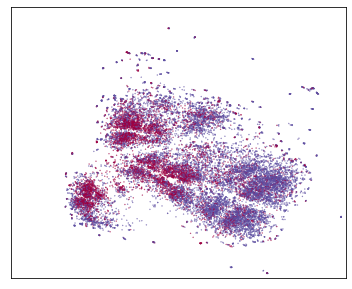

In [38]:
t_ce_tr_te_plot = t_ce_tr_te.copy()
y_umap_tr_te = np.concatenate((y_train, y_test+2))


plt.figure(figsize=[6,5])
plt.scatter(-t_ce[:,0], t_ce[:,1], 
            c=y_train, s=0.1, cmap='Spectral')

plt.xlim([-8,40])
plt.ylim([-10,40])

plt.xticks([])
plt.yticks([])

plt.savefig('Shortness/yale_short_ce.png', bbox_inches='tight', dpi=DPI)



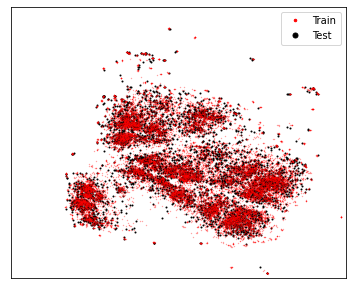

In [39]:
#plt.figure(figsize=(15,15))
from matplotlib.lines import Line2D
plt.figure(figsize=[6,5])
plt.scatter(-t_ce_test[:,0], t_ce_test[:,1], c=c1, s=1.0)
plt.scatter(-t_ce[:,0], t_ce[:,1], c=c2, s=0.1, alpha=0.5)

legend_elements = [Line2D([0], [0], marker='.', markersize=5, lw=0, color=c2, label='Train'),
                   Line2D([0], [0], marker='.', markersize=10, lw=0, color=c1, label='Test')]

plt.legend(handles=legend_elements)

plt.xlim([-8,40])
plt.ylim([-10,40])

plt.xticks([])
plt.yticks([])

plt.savefig('Shortness/yale_short_ce_repulsioneffect.png', bbox_inches='tight', dpi=DPI)

<h1>UMAP MSE</h1>

In [40]:
from scipy.io import loadmat

d = loadmat('nets_MSE_UMAP_fmnist/test_data19.mat')
t_mse = d['Y'].copy()
t_mse_test = d['Y_test'].copy()
t_mse_tr_te = np.concatenate((d['Y'],d['Y_test'])).copy()


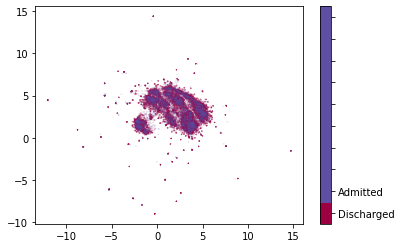

In [41]:
plt.figure()
plt.scatter(t_mse_tr_te[:,0], t_mse_tr_te[:,1], c=y_all, s=0.01, cmap='Spectral')

cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)

In [42]:
from sklearn.neighbors import KNeighborsClassifier

print('Nearest Neighbor: UMAP MSE (TRAIN->TEST)')

neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(t_mse, y_train)

y_nene_out = neigh.predict(t_mse_test)

err_mse = 1-np.mean(y_nene_out==y_test)

print('1-NN error: ', err_mse)

from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(t_mse, y_train)

y_nene_out = neigh.predict(t_mse_test)

err_mse_5 = 1-np.mean(y_nene_out==y_test)
print('5-NN error: ', err_mse_5)


Nearest Neighbor: UMAP MSE (TRAIN->TEST)
1-NN error:  0.35753396876901233
5-NN error:  0.3094706955992699


In [43]:
tt_mse_5 = my_trustworthiness(t_mse_tr_te, sort_idx, K=5)
tt_mse_30 = my_trustworthiness(t_mse_tr_te, sort_idx, K=30)
tt_mse_100 = my_trustworthiness(t_mse_tr_te, sort_idx, K=100)

print('UMAP MSE')
print('Trustworthiness: (Train->Test) ')
print('5: ', tt_mse_5)
print('30: ', tt_mse_30)
print('100: ', tt_mse_100)

tt_mse_5 = my_trustworthiness(t_mse, sort_idx_tr, K=5)
tt_mse_30 = my_trustworthiness(t_mse, sort_idx_tr, K=30)
tt_mse_100 = my_trustworthiness(t_mse, sort_idx_tr, K=100)

print('Trustworthiness: (Train) ')
print('5: ', tt_mse_5)
print('30: ', tt_mse_30)
print('100: ', tt_mse_100)

#Epoch 29
#Trustworthiness: (Train->Test) 
#5:  0.8730013667003098
#30:  0.8568916974762673
#100:  0.8404136352261815
#Trustworthiness: (Train) 
#5:  0.8798667745838696
#30:  0.8577890513415286
#100:  0.8404720549608092


UMAP MSE
Trustworthiness: (Train->Test) 
5:  0.7997288290991449
30:  0.7803223910998744
100:  0.7693712671891205
Trustworthiness: (Train) 
5:  0.8119298213013763
30:  0.785855632461322
100:  0.7741084904039102


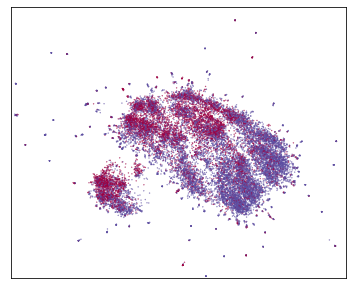

In [44]:
t_ce_tr_te_plot = t_mse_tr_te.copy()
y_umap_tr_te = np.concatenate((y_train, y_test+2))


plt.figure(figsize=[6,5])
plt.scatter(t_mse[:,0], t_mse[:,1], 
            c=y_train, s=0.1, cmap='Spectral')

plt.xlim([-6,8])
plt.ylim([-2.5,10])

plt.xticks([])
plt.yticks([])

plt.savefig('Shortness/yale_short_mse.png', bbox_inches='tight', dpi=DPI)

#Create the Colorbar

#cbar = plt.colorbar() #boundaries=np.arange(11)-0.5

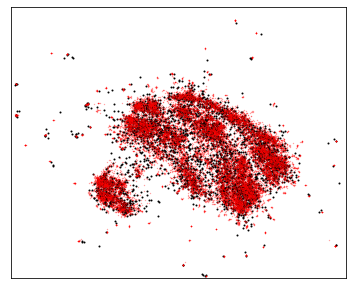

In [45]:
from matplotlib.lines import Line2D
plt.figure(figsize=[6,5])

plt.scatter(t_mse_test[:,0], t_mse_test[:,1], c=c1, s=1.0)
plt.scatter(t_mse[:,0], t_mse[:,1], c=c2, s=0.1, alpha=0.5)

plt.xlim([-6,8])
plt.ylim([-2.5,10])

plt.xticks([])
plt.yticks([])

plt.savefig('Shortness/yale_short_mse_repulsioneffect.png', bbox_inches='tight', dpi=DPI)

<h1>UMAP CEMSE</h1>

In [46]:
from scipy.io import loadmat

d = loadmat('nets_MSE_CE_UMAP_fmnist/test_data19.mat')
t_cemse = d['Y'].copy()
t_cemse_test = d['Y_test'].copy()
t_cemse_tr_te = np.concatenate((d['Y'],d['Y_test'])).copy()


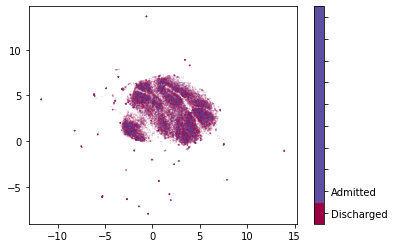

In [47]:
plt.figure()
plt.scatter(t_cemse_tr_te[:,0], t_cemse_tr_te[:,1], c=y_all, s=0.01, cmap='Spectral')

cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)

In [48]:
from sklearn.neighbors import KNeighborsClassifier

print('Nearest Neighbor: UMAP CEMSE (TRAIN->TEST)')

neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(t_cemse, y_train)

y_nene_out = neigh.predict(t_cemse_test)

err_cemse = 1-np.mean(y_nene_out==y_test)

print('1-NN error: ', err_cemse)

from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(t_cemse, y_train)

y_nene_out = neigh.predict(t_cemse_test)

err_cemse_5 = 1-np.mean(y_nene_out==y_test)
print('5-NN error: ', err_cemse_5)


Nearest Neighbor: UMAP CEMSE (TRAIN->TEST)
1-NN error:  0.34901642668829846
5-NN error:  0.3015615493814642


In [49]:
tt_cemse_5 = my_trustworthiness(t_cemse_tr_te, sort_idx, K=5)
tt_cemse_30 = my_trustworthiness(t_cemse_tr_te, sort_idx, K=30)
tt_cemse_100 = my_trustworthiness(t_cemse_tr_te, sort_idx, K=100)

print('UMAP CEMSE')
print('Trustworthiness: (Train->Test) ')
print('5: ', tt_cemse_5)
print('30: ', tt_cemse_30)
print('100: ', tt_cemse_100)

tt_cemse_5 = my_trustworthiness(t_cemse, sort_idx_tr, K=5)
tt_cemse_30 = my_trustworthiness(t_cemse, sort_idx_tr, K=30)
tt_cemse_100 = my_trustworthiness(t_cemse, sort_idx_tr, K=100)

print('Trustworthiness: (Train) ')
print('5: ', tt_cemse_5)
print('30: ', tt_cemse_30)
print('100: ', tt_cemse_100)

#Epoch 29
#Trustworthiness: (Train->Test) 
#5:  0.8730013667003098
#30:  0.8568916974762673
#100:  0.8404136352261815
#Trustworthiness: (Train) 
#5:  0.8798667745838696
#30:  0.8577890513415286
#100:  0.8404720549608092


UMAP CEMSE
Trustworthiness: (Train->Test) 
5:  0.8070773556150272
30:  0.7982620670787147
100:  0.7870969897835202
Trustworthiness: (Train) 
5:  0.8121848413172821
30:  0.7997890944099272
100:  0.7887205560775599


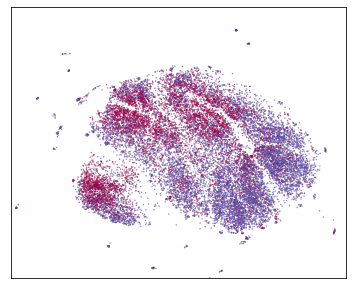

In [50]:
#from matplotlib.colors import ListedColormap

#a = 0.5

# Get the colormap colors, multiply them with the factor "a", and create new colormap
#my_cmap = plt.cm.jet(np.arange(plt.cm.RdBu.N))
#my_cmap[:,0:3] *= a 
#my_cmap = ListedColormap(my_cmap)

t_cemse_tr_te_plot = t_cemse_tr_te.copy()
y_umap_tr_te = np.concatenate((y_train, y_test+2))


plt.figure(figsize=[6,5])
#plt.scatter(t_cemse_tr_te_plot[:,0], t_cemse_tr_te_plot[:,1], 
#            c=y_umap_tr_te, s=0.1, cmap='Spectral')

plt.scatter(t_cemse[:,0], t_cemse[:,1], 
            c=y_train, s=0.1, cmap='Spectral')

#plt.scatter(t_cemse_test[:,0], t_cemse_test[:,1], 
#            c=y_test, s=0.1, cmap='cool')



plt.xlim([-6,8])
plt.ylim([-2.5,10])

plt.xticks([])
plt.yticks([])


plt.savefig('Shortness/yale_short_cemse.png', bbox_inches='tight', dpi=DPI)

#Create the Colorbar

#cbar = plt.colorbar() #boundaries=np.arange(11)-0.5

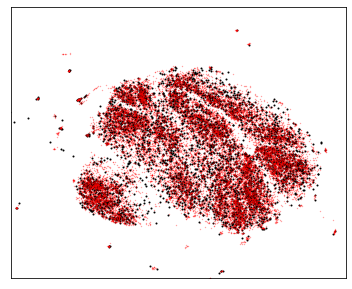

In [51]:
from matplotlib.lines import Line2D
plt.figure(figsize=[6,5])

plt.scatter(t_cemse_test[:,0], t_cemse_test[:,1], c=c1, s=1.0)
plt.scatter(t_cemse[:,0], t_cemse[:,1], c=c2, s=0.1, alpha=0.5)

plt.xlim([-6,8])
plt.ylim([-2.5,10])

plt.xticks([])
plt.yticks([])

plt.savefig('Shortness/yale_short_cemse_repulsioneffect.png', bbox_inches='tight', dpi=DPI)